# 虛擬環境

In [ ]:
""" dlamp_old
mb create -n dlamp_old -c conda-forge python=3.10 # only python 3.10 can install torch 1.12.1
mba dlamp
pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113
pip install lightning==2.1 torch==1.12.1
pip install onnxruntime-gpu==1.10 # due to cuda 11.3
pip install --force-reinstall -v "numpy==1.25.2"
pip install hydra-core --upgrade
pip install ipykernel geopandas pydantic einops wandb matplotlib
pip install scikit-learn scipy
"""

""" dlamp
mb create -n dlamp -c conda-forge python=3.11
mba dlamp
pip install torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cu118
pip install hydra-core --upgrade
pip install onnxruntime-gpu==1.17 # due to cuda 11.8
pip install scikit-learn scipy lightning einops wandb
pip install ipykernel geopandas pydantic matplotlib
pip install xarray
"""

# 安外/安內

In [ ]:
""" data mover
scp .kshrc com134@172.17.90.158:/nwpr/wfc/com134
.bashrc .bash_profile .ssh/authorized_keys .local/bin/micromamba micromamba/ DLAMP/
** change the pip interpreter
which pip
vi /IFS/nwpr/wfc/com134/micromamba/envs/dlamp/bin/pip
"""

""" 到新環境的SOP
1. 透過CPU cores及max_user_process(`ulimit -a`)來決定workers
2. GPU VRAM決定batch size, 測試時使用limit_train_batches=limit_val_batches=10, 並記錄時間
3. total data / (sampling rate * batch size * GPUs) = num_steps / epoch
4. 結合2, 3可以算出一個epoch要花多少時間
5. 算出 duration / epoch後即可估計 min_steps, log_every_n_steps, log_image_every_n_steps, 

blacklist: 
2024-01-25 19:00 and 2024-01-25 20:00
2022-03-30 23:00 and 2022-03-31 00:00
"""

"""資料回傳
find . -type d -regex "./2022-09-1[1-3]_[0-2][0-9]" | tar -cvzf ~/RWRF_data_2022_09_11_to_2022_09_13.tar.gz -T -
或
tar -cvzf ~/RWRF_data_2020_07_01.tar.gz 2020-07-01_00/

curl -X POST -F "file=@logs.tar.gz" 140.112.67.171/upload
tar -xvzf RWRF_data_2022_09_11_to_2022_09_13.tar.gz -C /your/destination/ # unzip
"""

# Terrain

In [ ]:
import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from src.const import LAND_SEA_MASK_PATH, TOPOGRAPHY_MASK_PATH

land_mask = torch.from_numpy(np.load(LAND_SEA_MASK_PATH).astype(np.float32))
topography_mask = torch.from_numpy(
    np.load(TOPOGRAPHY_MASK_PATH).astype(np.float32)
)
# Scale and shift to the range of [0, 1]
scaler = MinMaxScaler().fit(topography_mask.reshape(-1, 1))
scale = scaler.scale_.astype(np.float32)
min = scaler.min_.astype(np.float32)
topography_mask = topography_mask * scale + min

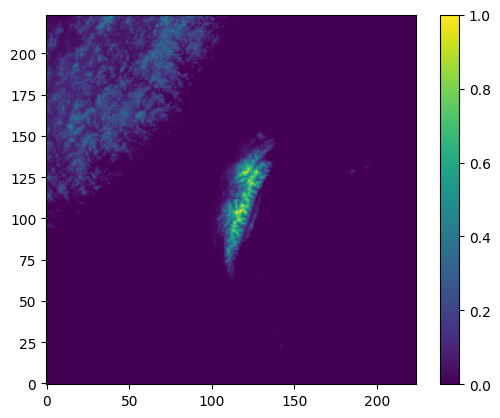

In [3]:
import matplotlib.pyplot as plt

plt.imshow(topography_mask.squeeze().numpy(), origin="lower")
plt.colorbar()
plt.show()

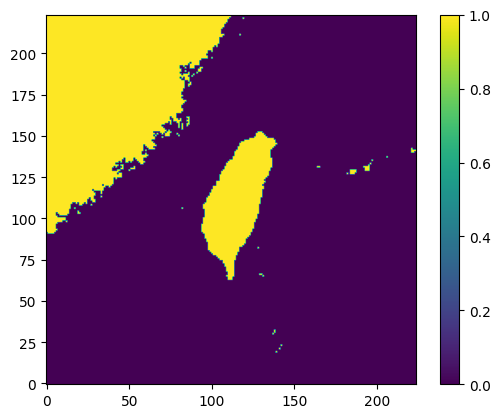

In [4]:
plt.imshow(land_mask.squeeze().numpy(), origin="lower")
plt.colorbar()
plt.show()

# Complete RWRF data

In [5]:
import xarray as xr

ds = xr.open_dataset('/nwpr/gfs/xb93/data2/tools/rwrf_data/RWRF_2021-01/2021-01-05_23/wrfout_d01_2021-01-06_00_interp')
# ds = xr.open_dataset('/nwpr/gfs/xb93/data2/tools/rwrf_data/RWRF_2024-01/2024-01-25_20/wrfout_d01_2024-01-25_20_interp')
# terrain = ds["HGT"].values
ds.variables

Frozen({'Times': <xarray.Variable (Time: 1)> Size: 19B
[1 values with dtype=|S19], 'XLAT': <xarray.Variable (Time: 1, south_north: 450, west_east: 450)> Size: 810kB
[202500 values with dtype=float32]
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    stagger:      
    description:  LATITUDE, SOUTH IS NEGATIVE
    units:        degree_north, 'XLONG': <xarray.Variable (Time: 1, south_north: 450, west_east: 450)> Size: 810kB
[202500 values with dtype=float32]
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    stagger:      
    description:  LONGITUDE, WEST IS NEGATIVE
    units:        degree_east, 'pres_levels': <xarray.Variable (pres_bottom_top: 31)> Size: 124B
[31 values with dtype=float32], 'HGT': <xarray.Variable (Time: 1, south_north: 450, west_east: 450)> Size: 810kB
[202500 values with dtype=float32]
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    stagger:      
    description:  Terrain Height
    units:        m, 'LANDMASK': <xarray.Variable (Time

In [3]:
ds["pres_levels"].values

array([1000.,  975.,  950.,  925.,  900.,  875.,  850.,  825.,  800.,
        775.,  750.,  700.,  650.,  600.,  550.,  500.,  450.,  400.,
        350.,  300.,  250.,  225.,  200.,  175.,  150.,  125.,  100.,
         70.,   50.,   30.,   20.], dtype=float32)

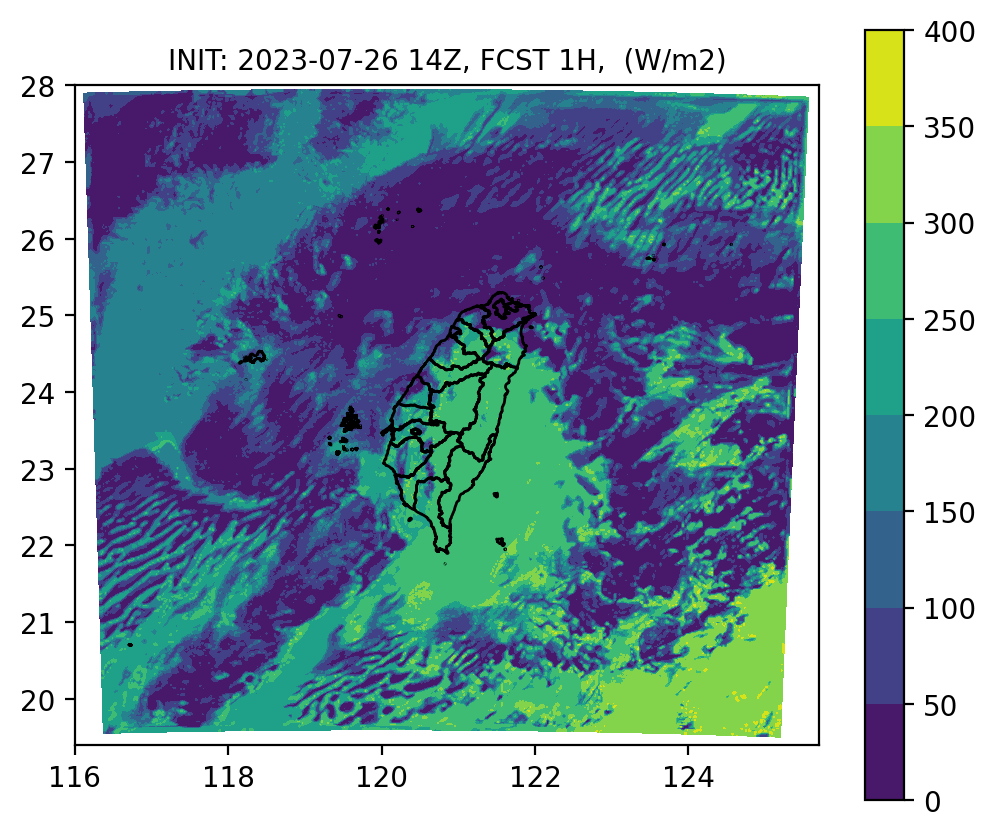

In [4]:
import matplotlib.pyplot as plt
import geopandas as gpd

lon = ds["XLONG"].values.squeeze() # (450, 450)
lat = ds["XLAT"].values.squeeze( )# (450, 450)
data = ds["SWDOWN"].values.squeeze()

# coastal line
county_data = gpd.read_file("./assets/town_shp/COUNTY_MOI_1090820.shp")
fig, ax = plt.subplots(1, 1, figsize=(6, 5), dpi=200, facecolor="w")
ax = county_data.plot(
	ax=ax, color="none", edgecolor="k", linewidth=1, zorder=1
)
ax.set_xlim(116, 125.7)  # RWRF
ax.set_ylim(19.4, 28)  # RWRF

# plot
cf = ax.contourf(lon, lat, data, zorder=0)
ax.set_title("INIT: 2021-01-05 14Z, FCST 1H,  (W/m2)", size=10)
cbar = fig.colorbar(cf)